# Simulation data

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob
import numpy as np

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

%load_ext autoreload
%autoreload 2

module_path = '..'
if module_path not in sys.path:
    sys.path.append(module_path)

import cellshapy

Reading config from /home/debacwa/.config/cellshapy


../cellshapy/config/features.py:23: UserWarning: Package pyefd is missing. Some features are not available
../cellshapy/config/features.py:23: UserWarning: Package stldecompose is missing. Some features are not available
../cellshapy/config/features.py:23: UserWarning: Package deap is missing. Some features are not available
../cellshapy/config/features.py:23: UserWarning: Package mahotas is missing. Some features are not available


# Import data

In [2]:
#data_folder = '/data/debacwa/cellshapy/dataset-apical-emergence/'
data_folder = '../../cellshapy_datasets/dataset-flywing'


- import annotation

In [22]:
import pandas as pd
import os
fn = os.path.join(data_folder, 'annotation.csv')
annotation = pd.read_csv(fn, index_col=0, squeeze=True).to_dict('records')

- import video data

In [23]:
path = os.path.join(data_folder, '*.tif')
import glob
filenames = sorted(glob.glob(path))
vc = cellshapy.VideoCollection.from_filenames(filenames, annotations=annotation, composite=True, normalize_distances=False)

Creating VideoCollection from list of paths. 576 video files or directories


Iteration 2, error: 0.000031, time: 16.29 sec
17280 contours aligned in 25.20 sec


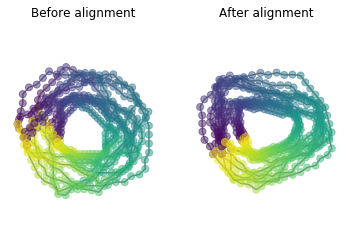

In [24]:
_ = vc.align_contours(show_samples=10)

In [25]:
#HTML(vc.show())

# Shape analysis

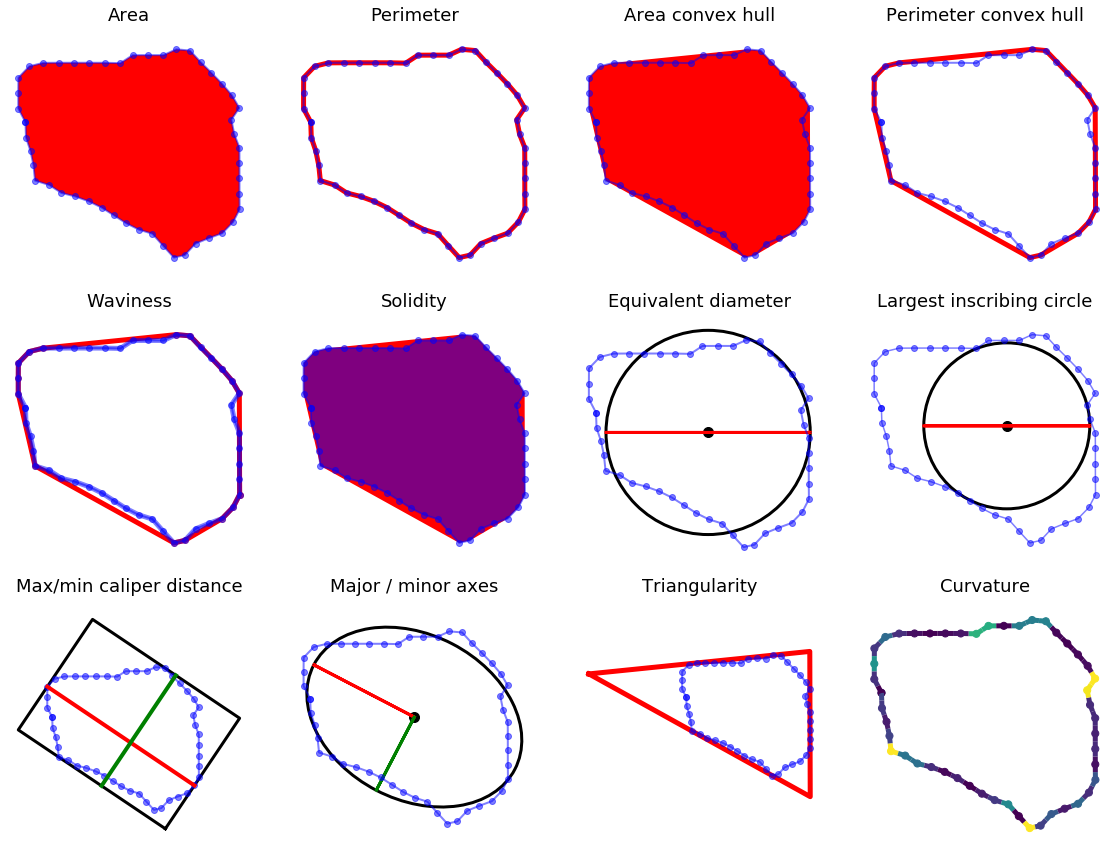

In [26]:
from cellshapy.utils.contours import extract_shape_descriptors
_ = vc[-2][-2].extract_shape_descriptors(plot=True, skeleton=False)

# Morph analysis

## VAE

`vae` embedding for `stxy`

../cellshapy/data/videocollection.py:717: UserWarning: VAE is experimental! Limited compatibility.
../cellshapy/analysis/vae.py:66: UserWarning: Tensor was zero-padded from (576, 30, 96) to (576, 32, 96).


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 48, 16)   160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 16, 48, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 48, 16)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

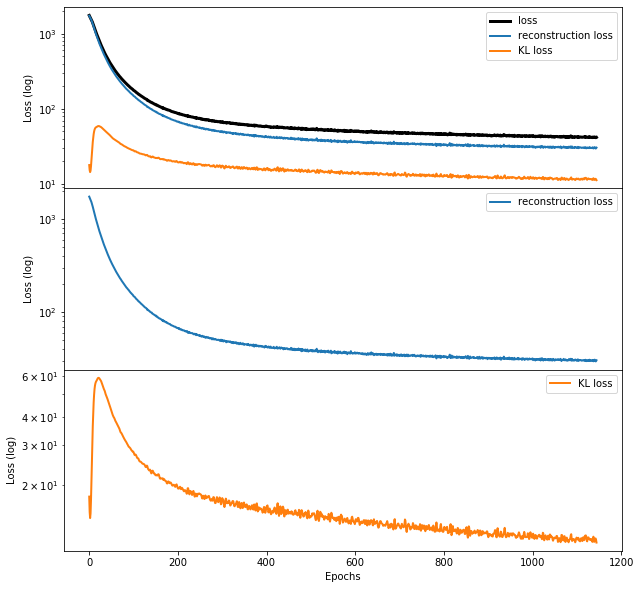

In [60]:
format = 'stxy'
vc.embed_morphs(format, 'vae', n_components=32, plot=False, verbose=True)

components = None


../cellshapy/plotting/morphspace.py:93: UserWarning: Projecting from 32 components to 2D using umap.


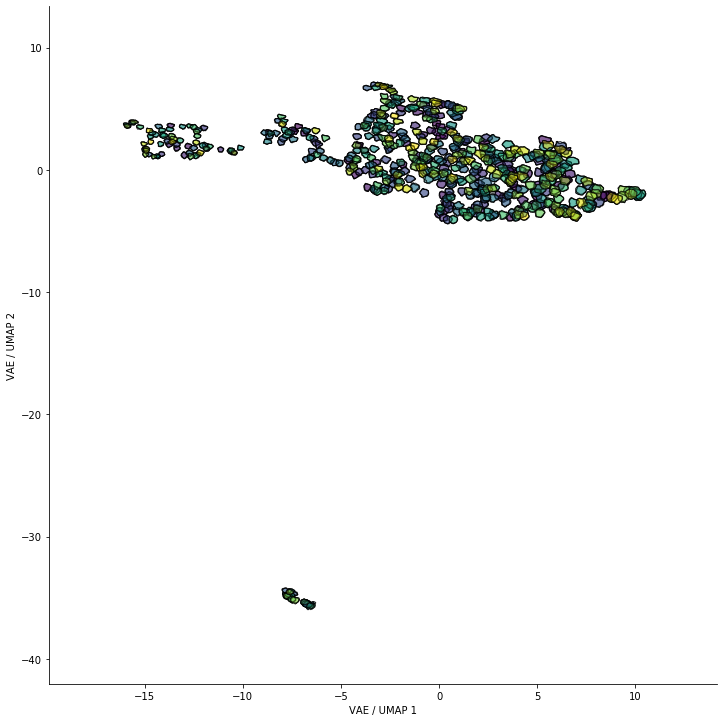

In [98]:
f=20
fig = vc.morph_space(format, 'vae', animate=False, frames=[f,f+2,f+4], 
                     shape_size=1, alpha_face=0.3, alpha_edge=0.7, 
                     colorcode='video', projection='umap')


(576, 32)


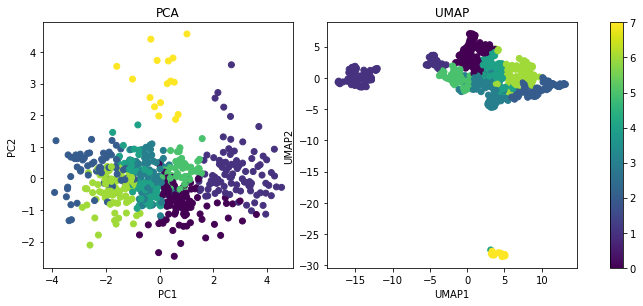

video  cluster
0        0        4
1        1        0
2        2        1
3        3        4
4        4        2
..     ...      ...
571    571        2
572    572        0
573    573        6
574    574        4
575    575        0

[576 rows x 2 columns]

In [188]:
df_clusters = vc.cluster_morphs(format='stxy', method='vae', 
                  cl_method='agglomerativeclustering', n_clusters=8, plot=True)
df_clusters

In [189]:
#annotations_cluster

In [190]:
np.unique(df_clusters['cluster'])

array([0, 1, 2, 3, 4, 5, 6, 7])

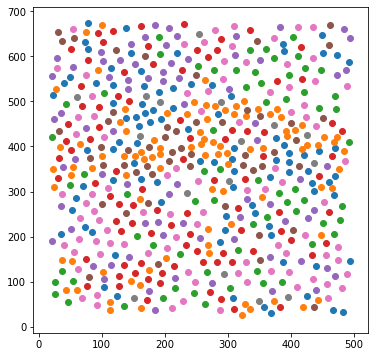

In [191]:
def plot_cluster_centroids(cluster_label):

    indices_cluster = df_clusters[df_clusters['cluster']==cluster_label].index.values
    annotations_cluster = np.array(annotation)[indices_cluster]
    centroids_cluster = np.array([eval(r['centroid']) for r in annotations_cluster])
    ax.scatter(centroids_cluster[:,1],centroids_cluster[:,2])

fig, ax = plt.subplots(1,1,figsize=(6,6))
    
for i in np.unique(df_clusters['cluster']):
    plot_cluster_centroids(i)

In [159]:
embeddings = vc.embedding[('stxy', 'vae')]
fig, ax = plt.subplots(len(embeddings.T), 1, figsize=(5,4*len(embeddings.T)))
for a, f in zip(ax, embeddings.T):
    a.stem(f)


/home/debacwa/miniconda3/envs/cellshapy/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2e6042c268> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f2e60002488> (for post_execute):


KeyboardInterrupt: 

- Reconstruct a sample

(1, 30, 48, 2)
(1, 30, 96)
(30, 96)
[[-0.2412861  -0.5662994   0.69001085  0.6133022  -0.35396865  0.50344294
   0.08649667 -0.6440385   0.44021523 -0.20808055 -0.21579696  0.13541228
   0.14076737 -0.1348431  -0.85246336 -0.83601975  0.11452679  1.173689
   0.51095647  0.64114344 -0.5733256   0.84202725 -0.5350345  -0.48928818
  -0.63081217  0.8885428   0.5341491  -0.93510246 -0.8757042  -0.75733614
   0.19289574  0.7070798 ]]
(1, 30, 96)


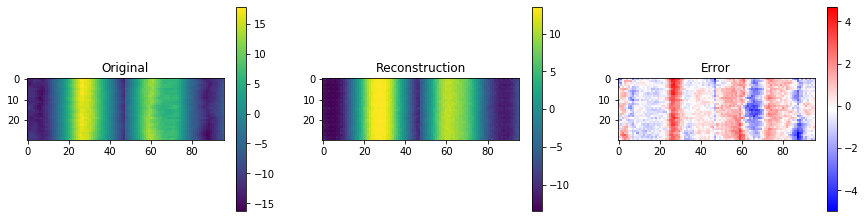

In [62]:
s = 0
# get sample of dynamic shape
sample = vc.get_contours(per_sample=True, aligned=True)[s:s+1]

print(sample.shape)

# reshape to get x and y coordinates in sigle axis
import numpy as np
sample = np.reshape(sample, (*sample.shape[:2], -1), order='F' )

print(sample.shape)

# zero-padding
#sample = [vc.embed_object['stxy', 'vae'].pad_to_next_divisible(s) for s in sample]

for s in sample:
    print(s.shape)

# encode it
encoding = vc.embed_object['stxy', 'vae'].transform( sample )
print(encoding)


# decode it
reconstruction = vc.embed_object['stxy', 'vae'].inverse_transform( encoding )

print(reconstruction.shape)

# plot matrices
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_title('Original')
p = ax[0].imshow(sample[0])
fig.colorbar(p, ax=ax[0], shrink=0.75)

ax[1].set_title('Reconstruction')
p = ax[1].imshow(reconstruction[0])
fig.colorbar(p, ax=ax[1], shrink=0.75)

ax[2].set_title('Error')
p = ax[2].imshow(sample[0]-reconstruction[0], cmap='bwr')
fig.colorbar(p, ax=ax[2], shrink=0.75)
plt.show()


In [57]:
# animate original and reconstructed contour
contour = cellshapy.analysis.embedding.tensor_to_contours(sample, format='stxy')
cellshapy.plotting.polygon.animate_contour(np.squeeze(contour), duration=3)


format =  stxy
(1, 30, 48, 2)


RuntimeError: Requested MovieWriter (ffmpeg) not available

In [58]:
contour = cellshapy.analysis.embedding.tensor_to_contours(reconstruction, format='stxy')
cellshapy.plotting.polygon.animate_contour(np.squeeze(contour), duration=3)

format =  stxy
(1, 30, 48, 2)


RuntimeError: Requested MovieWriter (ffmpeg) not available

## Parafac

`parafac` embedding for `stxy` done (1.21 s).


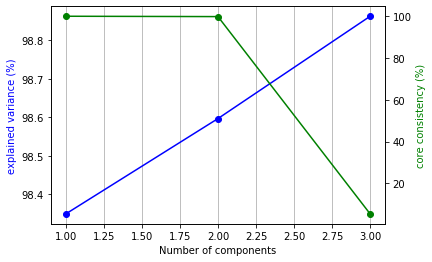

explained variance  core consistency
n_components                                      
1                      98.348625        100.000000
2                      98.596567         99.830410
3                      98.862672          5.372477

In [27]:
format = 'stxy'
vc.embed_morphs(format, 'parafac', n_components=2, save_embedding=True, plot=False)
df_corcondia, _ = vc.parafac_diagnostics(format, max_components=4)
df_corcondia

../cellshapy/plotting/morphspace.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


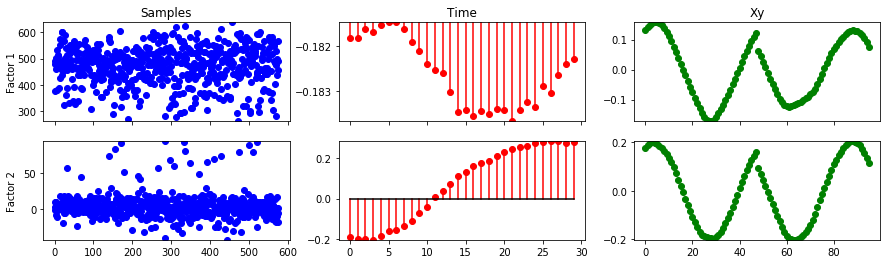

In [28]:
vc.embed_morphs(format, 'parafac', n_components=2, plot=True, verbose=False)

components = None


../cellshapy/plotting/morphspace.py:93: UserWarning: Projecting from 2 components to 2D using pca.


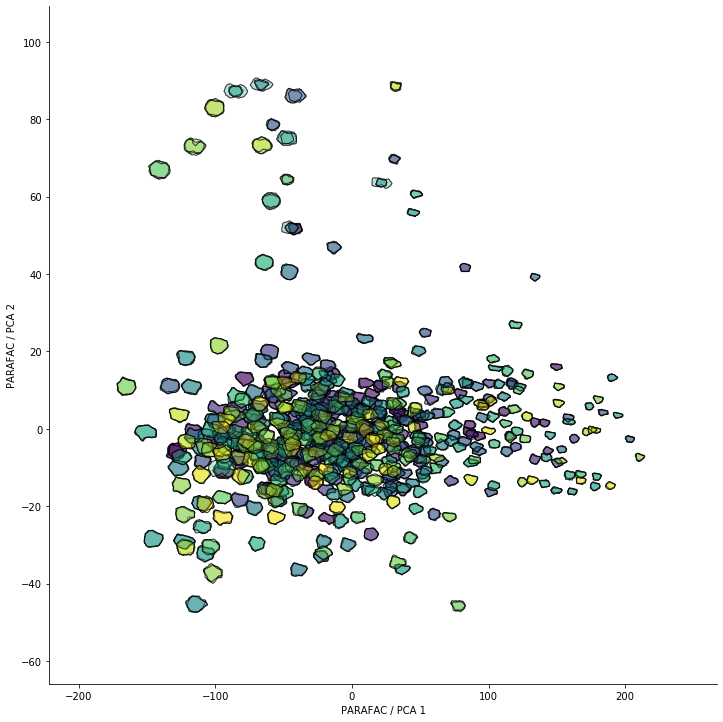

In [72]:
f = 10
fig = vc.morph_space(format, 'parafac', animate=False, frames=[f,f+2,f+4], 
                     shape_size=1, alpha_face=0.3, alpha_edge=0.7, 
                     colorcode='video', projection='pca')

../cellshapy/analysis/embedding.py:1354: UserWarning: Embedding do not have identical dimensionlity (2 != 32). Reducing dimensionality of the one with larger dimensionality with PCA.


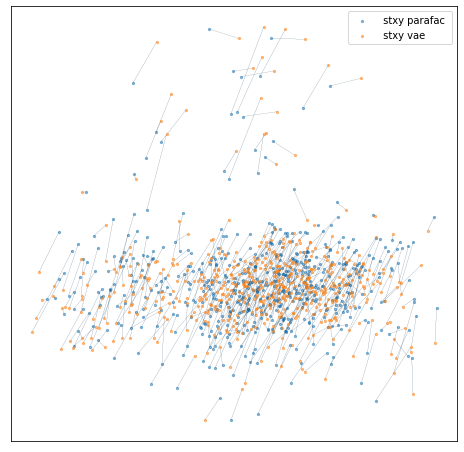

0.6468352307880308

In [63]:
vc.compare_embeddings(('stxy', 'parafac'),('stxy', 'vae'))

## Tucker

../cellshapy/plotting/morphspace.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


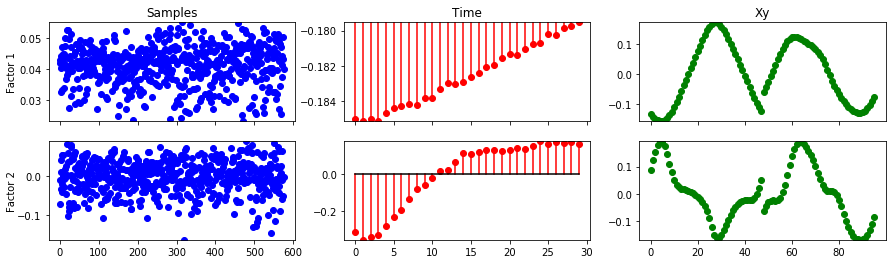

In [30]:
vc.embed_morphs(format, 'tucker', n_components=2, plot=True, verbose=False)

components = None


../cellshapy/plotting/morphspace.py:93: UserWarning: Projecting from 2 components to 2D using pca.


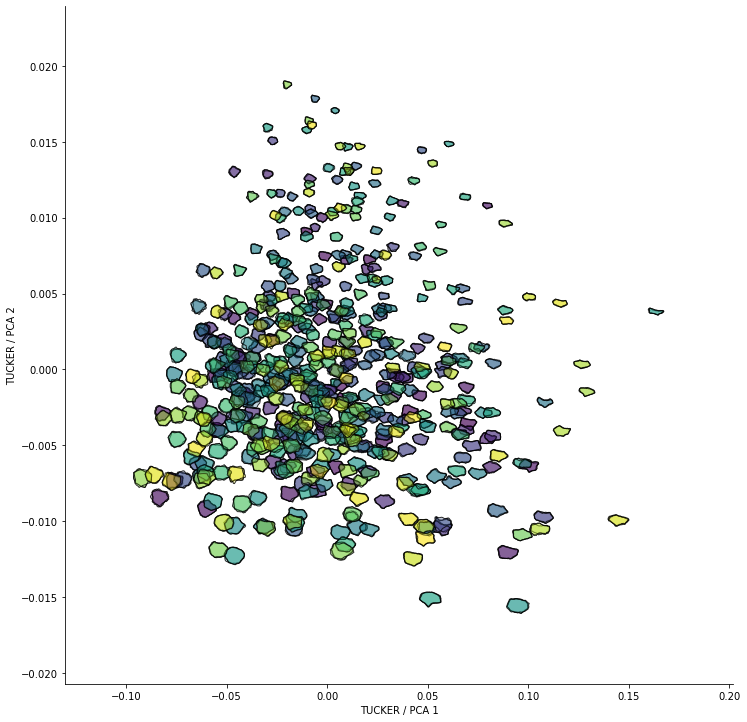

In [51]:
f = 20
fig = vc.morph_space(format, 'tucker', animate=False, frames=[f,f+2,f+4], 
                     shape_size=1, alpha_face=0.3, alpha_edge=0.7, colorcode='video', 
                     projection='pca')

# Comparison of embeddings

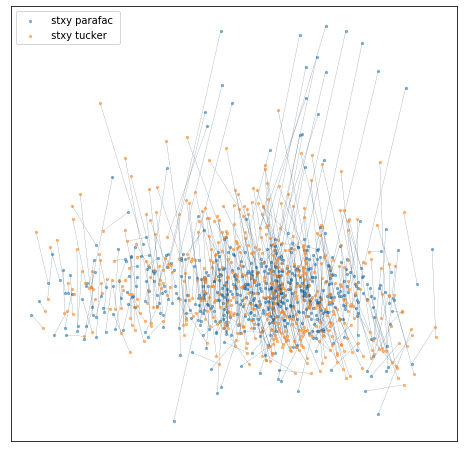

1.279340829922032

In [64]:
vc.compare_embeddings(('stxy', 'parafac'),('stxy', 'tucker'))

../cellshapy/analysis/embedding.py:1354: UserWarning: Embedding do not have identical dimensionlity (2 != 32). Reducing dimensionality of the one with larger dimensionality with PCA.


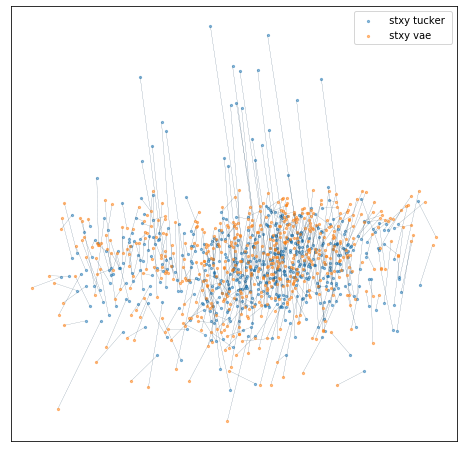

1.0829012053442437

In [65]:
vc.compare_embeddings(('stxy', 'tucker'),('stxy', 'vae'))